++- +-+-
+-
+--# Gaussian Mixture Models Implementation
Oscar Contreras Carrasco

Hi everyone! This is a full implementation of Gaussian Mixture Models in Python. I really hope you will find it useful to further understand how the algorithm works.

Let's first import the libraries we are going to be using throughout the exercise:-+ 

In [1]:
import sys
sys.path.append('lib')
import imageio
import matplotlib.animation as ani
import matplotlib.cm as cmx
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import numpy as np

from matplotlib.patches import Ellipse
from PIL import Image
from sklearn import datasets
from sklearn import mixture
from sklearn.cluster import KMeans
from gmr import *

import scipy.linalg as sp
from mpl_toolkits.mplot3d import Axes3D
from plot_utils import *

For the purposes of this exercise, we will be using the Iris dataset, which is probably already familiar to you. We can easily obtain it by using the __load_iris__ function provided by sklearn:

In [2]:
from scipy.io import loadmat # loading data from matlab

handover_data = loadmat('data/data_dyn.mat')
trq_in = handover_data['trq_in']
acc_out = handover_data['acc_out']
angle_out = handover_data['angle_out']
demos = np.concatenate((trq_in,acc_out,angle_out),axis=1)
print(demos.shape)
D=demos.shape[1]

(10001, 3)


In [3]:
iris = datasets.load_iris()
X = iris.data
print(X[:20])

X.shape

[[5.1 3.5 1.4 0.2]
 [4.9 3.  1.4 0.2]
 [4.7 3.2 1.3 0.2]
 [4.6 3.1 1.5 0.2]
 [5.  3.6 1.4 0.2]
 [5.4 3.9 1.7 0.4]
 [4.6 3.4 1.4 0.3]
 [5.  3.4 1.5 0.2]
 [4.4 2.9 1.4 0.2]
 [4.9 3.1 1.5 0.1]
 [5.4 3.7 1.5 0.2]
 [4.8 3.4 1.6 0.2]
 [4.8 3.  1.4 0.1]
 [4.3 3.  1.1 0.1]
 [5.8 4.  1.2 0.2]
 [5.7 4.4 1.5 0.4]
 [5.4 3.9 1.3 0.4]
 [5.1 3.5 1.4 0.3]
 [5.7 3.8 1.7 0.3]
 [5.1 3.8 1.5 0.3]]


(150, 4)

Let us now implement the Gaussian density function. Ahem... I know you can use numpy functions for that, but I believe it is actually interesting to see how things work internally. Our aim is to create a function that implements this:

\begin{equation}
\large
p(\mathbf x | \mathbf\mu, \mathbf\Sigma) = \frac 1 {({2\pi})^{n/2}|\Sigma|^{1/2}}\exp\left(-\frac 1 2 (\mathbf x -\mathbf\mu)^T\mathbf\Sigma^{-1}(\mathbf x -\mathbf\mu)\right)
\end{equation}


In [4]:
def gaussian(X, mu, cov):
    n = X.shape[1]
    diff = (X - mu).T
    return np.diagonal(1 / ((2 * np.pi) ** (n / 2) * np.linalg.det(cov) ** 0.5) * 
                       np.exp(-0.5 * np.dot(np.dot(diff.T, np.linalg.inv(cov)), diff))).reshape(-1, 1)

You can try this function by using the code in next cell. You should obtain something like:

array([[0.00159853],
       [0.00481869],
       [0.00276259],
       [0.0014309 ],
       [0.00143998]])

In [5]:
x0 = np.array([[0.05, 1.413, 0.212], [0.85, -0.3, 1.11], [11.1, 0.4, 1.5], [0.27, 0.12, 1.44], [88, 12.33, 1.44]])
print(x0.shape)
mu = np.mean(x0, axis=0)
print(mu)
cov = np.dot((x0 - mu).T, x0 - mu) / (x0.shape[0] - 1)

y = gaussian(x0, mu=mu, cov=cov)
y

(5, 3)
[20.054   2.7926  1.1404]


array([[0.00159853],
       [0.00481869],
       [0.00276259],
       [0.0014309 ],
       [0.00143998]])

__Step 1__

This is the initialization step of the GMM. At this point, we must initialise our parameters $\pi_k$, $\mu_k$, and $\Sigma_k$. In this case, we are going to use the results of KMeans as an initial value for $\mu_k$, set $\pi_k$ to one over the number of clusters and $\Sigma_k$ to the identity matrix. We could also use random numbers for everything, but using a sensible initialisation procedure will help the algorithm achieve better results.

In [6]:
def initialize_clusters(X, n_clusters):
    clusters = []
    idx = np.arange(X.shape[0])
    
    # We use the KMeans centroids to initialise the GMM
    
    kmeans = KMeans(n_clusters).fit(X)
    mu_k = kmeans.cluster_centers_
    
    for i in range(n_clusters):
        clusters.append({
            'pi_k': 1.0 / n_clusters,
            'mu_k': mu_k[i],
            'cov_k': np.identity(X.shape[1], dtype=np.float64)*100
        })
        
    return clusters

**clusters** *above is a list consisting of* **n_clusters** *number of dictionary. Each dictionary has three keys: pi_k, mu_k, cov_k*

In [7]:
def initialize_clusters_norm(X, n_clusters):
    clusters = []
    idx = np.arange(X.shape[0])
    
    # We use the KMeans centroids to initialise the GMM
    
    kmeans = KMeans(n_clusters).fit(X)
    mu_k = kmeans.cluster_centers_
    var_mat = np.diag(X.var(axis=0))
    for i in range(n_clusters):
        clusters.append({
            'pi_k': 1.0 / n_clusters,
            'mu_k': mu_k[i],
            'cov_k': np.identity(X.shape[1], dtype=np.float64)*var_mat
        })
        
    return clusters

**Step 2 (Expectation step)**

We should now calculate $\gamma(z_{nk})$. We can achieve this by means of the following expression:

\begin{equation}
\large
\gamma{(z_{nk})}=\frac {\pi_k\mathcal N(\mathbf x_n| \mathbf\mu_k, \mathbf\Sigma_k)}{\sum_{j=1}^K\pi_j\mathcal N(\mathbf x_n| \mathbf\mu_j, \mathbf\Sigma_j)}
\end{equation}

For convenience, we just calculate the denominator as a sum over all terms in the numerator, and then assign it to a variable named __totals__

In [8]:
def expectation_step(X, clusters):
    global gamma_nk, totals
    N = X.shape[0]
    K = len(clusters)
    totals = np.zeros((N, 1), dtype=np.float64)
    gamma_nk = np.zeros((N, K), dtype=np.float64)
    
    for k, cluster in enumerate(clusters):
        pi_k = cluster['pi_k']
        mu_k = cluster['mu_k']
        cov_k = cluster['cov_k']
    
        gamma_nk[:, k] = (pi_k * gaussian(X, mu_k, cov_k)).ravel()
    
    #now gamma_nk has N-long (time series) data in the first dimension (row) and k cluster's value in the second dim (column)  
    
    totals = np.sum(gamma_nk, 1)
    
    #summing N-long time series data keeping the second (axis=1) dimension's cluster's number
    # totals.shape = (1,k)
    
    gamma_nk /= np.expand_dims(totals, 1)
    
    # (N,k)개의 갯수를 가지는 gamma_nk의 각열 (=second dimension)을 (1,k)의 shape을 가지는 total으로 나눔

*When you use enumerate(), the function gives you back two loop variables:*

    >>> for count, value in enumerate(values):
- The **count** of the current iteration
- The **value** of the item at the current iteration

*Just like with a normal for loop, the loop variables can be named whatever you want them to be named. You use count and value in this example, but they could be named i and v or any other valid Python names.*

**gaussian** *generates the gaussian probability values for N-long data of X, which is flattened by .ravel() for each k th cluster.*

*Conclusively,* **gamma_nk** *has [N,k] dimension, and np.sum with axis=1 remains k dimension while summing N elements*

**Step 3 (Maximization step):**

Let us now implement the maximization step. Since $\gamma(z_{nk})$ is common to the expressions for $\pi_k$, $\mu_k$ and $\Sigma_k$, we can simply define:

\begin{equation}
\large
N_k=\sum_{n=1}^N\gamma({z_{nk}})
\end{equation}

And then we can calculate the revised parameters by using:

\begin{equation}
\large
\pi_k^*=\frac {N_k} N
\end{equation}


\begin{equation}
\large
\mu_k^*=\frac 1 {N_k} \sum_{n=1}^N\gamma({z_{nk}})\mathbf x_n
\end{equation}


\begin{equation}
\large
\Sigma_k^*=\frac 1 {N_k} \sum_{n=1}^N\gamma({z_{nk}})(\mathbf x_n-\mathbf\mu_k)(\mathbf x_n-\mathbf\mu_k)^T
\end{equation}

Note: To calculate the covariance, we define an auxiliary variable __diff__ that contains $(x_n-\mu_k)^T$.

In [10]:
def maximization_step(X, clusters):
    global gamma_nk
    N = float(X.shape[0])
  
    for k, cluster in enumerate(clusters):
        gamma_k = np.expand_dims(gamma_nk[:, k], 1)
        N_k = np.sum(gamma_k, axis=0)
        # 먼저 각 (N,k)의 크기를 가지는 gamma_nk의 각 행별 값을 더해 열(axis=1, cluster의 의미)만 남김
        
        pi_k = N_k / N
        mu_k = np.sum(gamma_k * X, axis=0) / N_k
        cov_k = (gamma_k * (X - mu_k)).T @ (X - mu_k) / N_k
        # pi_k: 모든 시계열이 가지는 gamma_nk값을 각 클러스터 별로 더한 값을 시계열의 크기로 나눈값
        # mu_k: 모든 시계열에 (이경우 3차원 데이터) gamma_nk를 각각 곱한 값을 각 클러스터별 gamma_nk의 합계로 나눈 값
        # cov_k: 모든 시계열의 mu_k에 대한 분산에 gamma_nk를 각각 곱한 값을 각 클러스터별 gamma_nk의 합계로 나눈 값
        
        cluster['pi_k'] = pi_k
        cluster['mu_k'] = mu_k
        cluster['cov_k'] = cov_k

Let us now determine the log-likelihood of the model. It is given by:

\begin{equation}
\large
\ln p(\mathbf X)=\sum_{n=1}^N\ln\sum_{k=1}^K\pi_k\mathcal N(\mathbf x_n|\mu_k,\Sigma_k)
\end{equation}

However, the second summation has already been calculated in the __expectation_step__ function and is available in the __totals__ variable. So we just make use of it.

In [11]:
def get_likelihood(X, clusters):
    global gamma_nk, totals
    sample_likelihoods = np.log(totals)
    return np.sum(sample_likelihoods), sample_likelihoods

Finally, let's put everything together! First, we are going to initialise the parameters by using the __initialise_clusters__ function, and then perform several expectation-maximization steps. In this case, we set the number of iterations of the training procedure to a fixed __n_epochs__ number. I have done this on purpose to generate graphs of the log-likelihood later.

In [12]:
def train_gmm(X, n_clusters, n_epochs):
    #clusters = initialize_clusters(X, n_clusters)
    clusters = initialize_clusters_norm(X, n_clusters)
    likelihoods = np.zeros((n_epochs, ))
    scores = np.zeros((X.shape[0], n_clusters))
    history = []

    for i in range(n_epochs):
        clusters_snapshot = []
        
        # This is just for our later use in the graphs
        for cluster in clusters:
            clusters_snapshot.append({
                'mu_k': cluster['mu_k'].copy(),
                'cov_k': cluster['cov_k'].copy()
            })
            
        history.append(clusters_snapshot)
      
        expectation_step(X, clusters)
        maximization_step(X, clusters)

        likelihood, sample_likelihoods = get_likelihood(X, clusters)
        likelihoods[i] = likelihood

        print('Epoch: ', i + 1, 'Likelihood: ', likelihood)

    scores = np.log(gamma_nk)
    
    return clusters, likelihoods, scores, sample_likelihoods, history

Let's train our model!

In [96]:
n_clusters = 3
n_epochs = 50

clusters, likelihoods, scores, sample_likelihoods, history = train_gmm(X, n_clusters, n_epochs)

Epoch:  1 Likelihood:  -648.7389009266919
Epoch:  2 Likelihood:  -239.21245430380202
Epoch:  3 Likelihood:  -204.18505552886913
Epoch:  4 Likelihood:  -199.82431529485598
Epoch:  5 Likelihood:  -195.25343091582863
Epoch:  6 Likelihood:  -191.15770446230943
Epoch:  7 Likelihood:  -188.68728032439
Epoch:  8 Likelihood:  -187.27326652594712
Epoch:  9 Likelihood:  -186.10210156717912
Epoch:  10 Likelihood:  -184.99421701706115
Epoch:  11 Likelihood:  -184.03035354362737
Epoch:  12 Likelihood:  -183.18167667438956
Epoch:  13 Likelihood:  -182.46864974330154
Epoch:  14 Likelihood:  -181.89328423040416
Epoch:  15 Likelihood:  -181.32044827272162
Epoch:  16 Likelihood:  -180.70841201453237
Epoch:  17 Likelihood:  -180.35437937486998
Epoch:  18 Likelihood:  -180.23762699589003
Epoch:  19 Likelihood:  -180.2017469499819
Epoch:  20 Likelihood:  -180.19058957202952
Epoch:  21 Likelihood:  -180.18709391024865
Epoch:  22 Likelihood:  -180.18599079624317
Epoch:  23 Likelihood:  -180.1856407930366
Epo

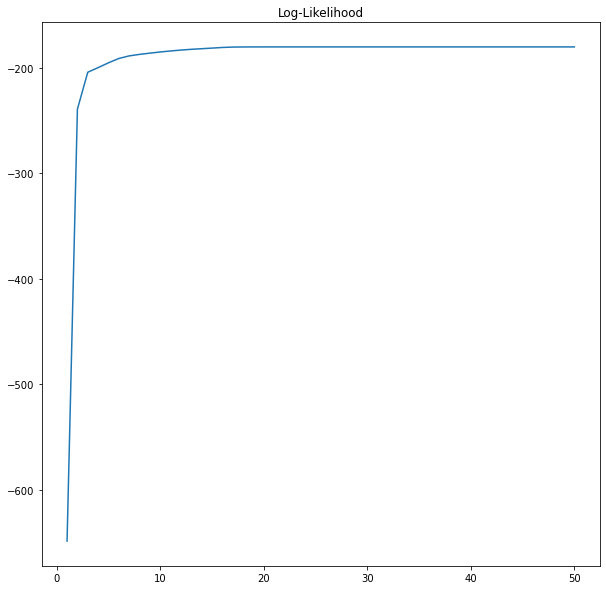

In [97]:
plt.figure(figsize=(10, 10))
plt.title('Log-Likelihood')
plt.plot(np.arange(1, n_epochs + 1), likelihoods)
plt.show()

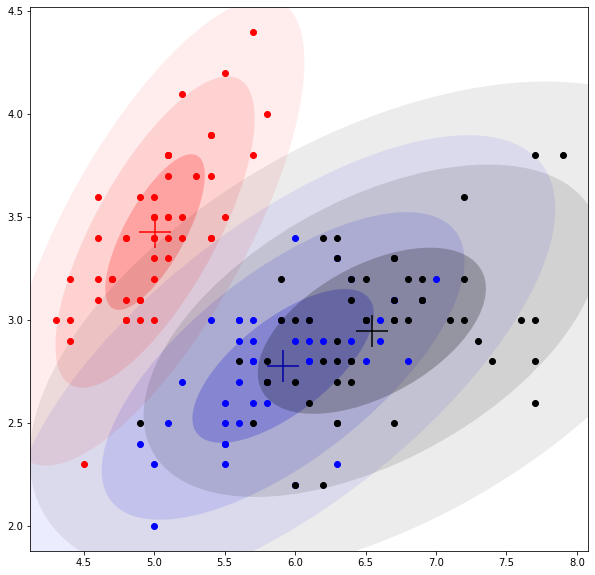

In [98]:
def create_cluster_animation(X, history, scores):
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    colorset = ['blue', 'red', 'black']
    images = []
    
    for j, clusters in enumerate(history):
      
        idx = 0
      
        if j % 3 != 0:
            continue
        
        plt.cla()
        
        for cluster in clusters:
            mu = cluster['mu_k']
            cov = cluster['cov_k']

            eigenvalues, eigenvectors = np.linalg.eigh(cov)
            order = eigenvalues.argsort()[::-1]
            eigenvalues, eigenvectors = eigenvalues[order], eigenvectors[:, order]
            vx, vy = eigenvectors[:,0][0], eigenvectors[:,0][1]
            theta = np.arctan2(vy, vx)

            #print(idx)
            color = colors.to_rgba(colorset[idx])

            for cov_factor in range(1, 4):
                ell = Ellipse(xy=mu, width=np.sqrt(eigenvalues[0]) * cov_factor * 2, 
                              height=np.sqrt(eigenvalues[1]) * cov_factor * 2, angle=np.degrees(theta), linewidth=2)
                ell.set_facecolor((color[0], color[1], color[2], 1.0 / (cov_factor * 4.5)))
                ax.add_artist(ell)

            ax.scatter(cluster['mu_k'][0], cluster['mu_k'][1], c=colorset[idx], s=1000, marker='+')
            idx += 1

        for i in range(X.shape[0]):
            ax.scatter(X[i, 0], X[i, 1], c=colorset[np.argmax(scores[i])], marker='o')
        
        fig.canvas.draw()
        
        image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
        image = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))

        images.append(image)
    
    kwargs_write = {'fps':1.0, 'quantizer':'nq'}
    imageio.mimsave('./gmm.gif', images, fps=1)
    plt.show(Image.open('gmm.gif').convert('RGB'))
    
    
create_cluster_animation(X, history, scores)

It is always a good idea to see how the log-likelihood is making progress. So let's create a graph reflecting that value

In [99]:
from sklearn.mixture import GaussianMixture

gmm = GaussianMixture(n_components=n_clusters, max_iter=50).fit(X)
gmm_scores = gmm.score_samples(X)

print('Means by sklearn:\n', gmm.means_)
print('Means by our implementation:\n', np.array([cluster['mu_k'].tolist() for cluster in clusters]))
print('Scores by sklearn:\n', gmm_scores[0:20])
print('Scores by our implementation:\n', sample_likelihoods.reshape(-1)[0:20])

Means by sklearn:
 [[6.54639415 2.94946365 5.48364578 1.98726565]
 [5.006      3.428      1.462      0.246     ]
 [5.9170732  2.77804839 4.20540364 1.29848217]]
Means by our implementation:
 [[5.91496959 2.77784365 4.20155323 1.29696685]
 [5.006      3.428      1.462      0.246     ]
 [6.54454865 2.94866115 5.47955343 1.98460495]]
Scores by sklearn:
 [ 1.57050082  0.73787138  1.14436656  0.92913238  1.411028   -0.09451903
  0.05266884  1.62442195  0.27082378  0.16706624  0.83489877  0.77168582
  0.29597841 -1.79224582 -3.41557928 -2.10529279 -1.12995447  1.47503579
 -0.84612536  0.97699215]
Scores by our implementation:
 [ 1.57057947  0.73793642  1.14444614  0.92920539  1.41110417 -0.09448868
  0.05268031  1.62449505  0.27090462  0.16702226  0.83494742  0.77171947
  0.29597776 -1.79222469 -3.41562626 -2.1052825  -1.1300608   1.47509939
 -0.84608424  0.9770596 ]


## from here, learning of dynamics using GMM

In [13]:
n_clusters0 = 8
n_epochs = 50
clusters_me, likelihoods_me, scores_me, sample_likelihoods_me, history_me = train_gmm(demos, n_clusters0, n_epochs)

Epoch:  1 Likelihood:  -101287.61200391117
Epoch:  2 Likelihood:  -79262.39945749336
Epoch:  3 Likelihood:  -78034.68777990027
Epoch:  4 Likelihood:  -76655.28796097658
Epoch:  5 Likelihood:  -75283.73302722827
Epoch:  6 Likelihood:  -74076.85899245598
Epoch:  7 Likelihood:  -73001.35280627887
Epoch:  8 Likelihood:  -71955.99790599523
Epoch:  9 Likelihood:  -71068.65885507164


C:\Users\sehoo\AppData\Local\Temp\ipykernel_9156\1023163249.py:5: RuntimeWarning: overflow encountered in exp
  np.exp(-0.5 * np.dot(np.dot(diff.T, np.linalg.inv(cov)), diff))).reshape(-1, 1)


Epoch:  10 Likelihood:  -70535.11554665615
Epoch:  11 Likelihood:  -70205.2923164425
Epoch:  12 Likelihood:  -69934.53518710737
Epoch:  13 Likelihood:  -69657.34042417581
Epoch:  14 Likelihood:  -69334.55626878946
Epoch:  15 Likelihood:  -68958.97499606494
Epoch:  16 Likelihood:  -68630.39503646494
Epoch:  17 Likelihood:  -68304.28409430674
Epoch:  18 Likelihood:  -67946.29458256
Epoch:  19 Likelihood:  -67491.32583170784
Epoch:  20 Likelihood:  -66977.76195350925
Epoch:  21 Likelihood:  -66497.70847224584
Epoch:  22 Likelihood:  -66051.32163065835
Epoch:  23 Likelihood:  -65580.8673360702
Epoch:  24 Likelihood:  -65129.84543848052
Epoch:  25 Likelihood:  -64754.58179664024
Epoch:  26 Likelihood:  -64336.070516994696
Epoch:  27 Likelihood:  -63816.36626998369
Epoch:  28 Likelihood:  -63421.65899009851


C:\Users\sehoo\AppData\Local\Temp\ipykernel_9156\1023163249.py:4: RuntimeWarning: overflow encountered in multiply
  return np.diagonal(1 / ((2 * np.pi) ** (n / 2) * np.linalg.det(cov) ** 0.5) *


Epoch:  29 Likelihood:  -63205.04689873282
Epoch:  30 Likelihood:  -63060.64462173707
Epoch:  31 Likelihood:  -62943.266387024196
Epoch:  32 Likelihood:  -62831.43303510005
Epoch:  33 Likelihood:  -62697.23269379935
Epoch:  34 Likelihood:  -62560.502111157824
Epoch:  35 Likelihood:  -62453.87868506134
Epoch:  36 Likelihood:  -62360.50970600674
Epoch:  37 Likelihood:  -62272.51837094892
Epoch:  38 Likelihood:  -62181.9953190489
Epoch:  39 Likelihood:  -62077.286569315824
Epoch:  40 Likelihood:  -61980.80943995567
Epoch:  41 Likelihood:  -61902.44942817665
Epoch:  42 Likelihood:  -61844.12476057159
Epoch:  43 Likelihood:  -61804.24377235832
Epoch:  44 Likelihood:  -61775.12884207172
Epoch:  45 Likelihood:  -61757.842897497874
Epoch:  46 Likelihood:  -61746.36377899367
Epoch:  47 Likelihood:  -61737.423583878095
Epoch:  48 Likelihood:  -61729.43915024811
Epoch:  49 Likelihood:  -61721.27230019545
Epoch:  50 Likelihood:  -61712.075005811545


C:\Users\sehoo\AppData\Local\Temp\ipykernel_9156\2291692929.py:28: RuntimeWarning: divide by zero encountered in log
  scores = np.log(gamma_nk)


The following graph shows how the likelihood improves as learning continues

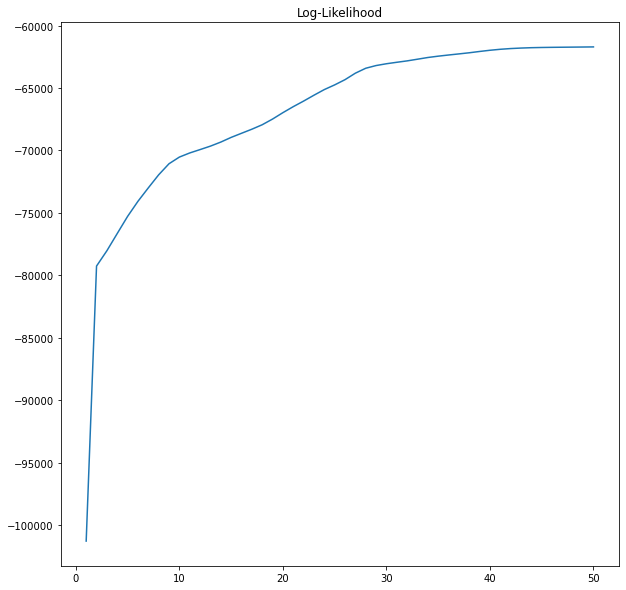

In [14]:
plt.figure(figsize=(10, 10))
plt.title('Log-Likelihood')
plt.plot(np.arange(1, n_epochs + 1), likelihoods_me)
plt.show()

In [16]:
'''
The following is to illustrates how the learning evolves.
But could not finish it because of:
1) colorset is only set to three clusters, but my case has eight clusters
2) the ellipse is depicted only in two dimensions, but my case has three dimensions
'''
def create_cluster_animation_me(X, history, scores):
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    colorset = ['blue', 'red', 'black']
    images = []
    
    for j, clusters in enumerate(history):
      
        idx = 0
        cluster_size=len(clusters)
        #print(x`cluster_size)
        
        if j % 1000 != 0:
            continue
        
        plt.cla()
        
        for cluster in clusters:
            mu = cluster['mu_k']
            cov = cluster['cov_k']

            eigenvalues, eigenvectors = np.linalg.eigh(cov)
            order = eigenvalues.argsort()[::-1]
            eigenvalues, eigenvectors = eigenvalues[order], eigenvectors[:, order]
            vx, vy = eigenvectors[:,0][0], eigenvectors[:,0][1]
            theta = np.arctan2(vy, vx)

            #print(idx/cluster_size)
            #color = colors.to_rgba(colorset[idx/cluster_size*3])
            color = (idx/cluster_size,1-idx/cluster_size,idx/cluster_size)
            #print(color)
            
            for cov_factor in range(1, 4):
                ell = Ellipse(xy=mu, width=np.sqrt(eigenvalues[0]) * cov_factor * 2, 
                              height=np.sqrt(eigenvalues[1]) * cov_factor * 2, angle=np.degrees(theta), linewidth=2)
                ell.set_facecolor((color[0], color[1], color[2], 1.0 / (cov_factor * 4.5)))
                ax.add_artist(ell)

            #ax.scatter(cluster['mu_k'][0], cluster['mu_k'][1], c=colorset[idx/cluster_size*3], s=1000, marker='+')
            ax.scatter(cluster['mu_k'][0], cluster['mu_k'][1], c=np.array([color]), s=1000, marker='+')
            print(np.array(color))
            idx += 1

        for i in range(X.shape[0]):
            #ax.scatter(X[i, 0], X[i, 1], c=colorset[np.argmax(scores[i])/cluster_size], marker='o')
            ax.scatter(X[i, 0], X[i, 1], c='black', marker='o')
        
        fig.canvas.draw()
        
        image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
        image = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))

        images.append(image)
    
    kwargs_write = {'fps':1.0, 'quantizer':'nq'}
    imageio.mimsave('./gmm.gif', images, fps=1)
    plt.show(Image.open('gmm.gif').convert('RGB'))

In [15]:
'''
So I tried to take out only the center (mu) values and the covariance as arrays only to failed.
array append function does not work properly even though the mu_k and cov_k of clusters are arrays

'''
def get_cov_and_mu_array(X, cluster_arg):
    #fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    #fig = plt.figure(figsize=(6,6))
    #ax = fig.add_subplot(111, projection='3d')
    
    for j, clusters in enumerate(cluster_arg):
      
        #print(j)
        #for cluster in clusters:
        mu = clusters['mu_k']
        cov = clusters['cov_k']

        if j == 0:
            mu_in_array=np.array([mu])
            cov_in_array=np.array([cov])
        else:
            #print(mu_in_array.shape)
            mu_in_array=np.append(mu_in_array,np.array([mu]),axis=0)
            #print(mu_in_array.shape)
            cov_in_array=np.append(cov_in_array,np.array([cov]),axis=0)
            
    return cov_in_array, mu_in_array

cov_array,mu_array=get_cov_and_mu_array(demos, clusters_me)

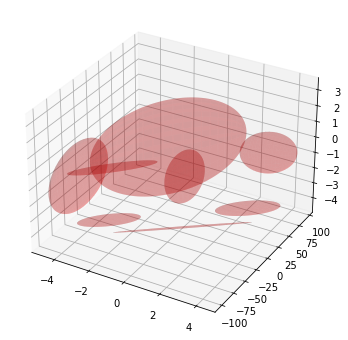

In [16]:
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111, projection='3d')
plot_gmm_3d(cov_array,mu_array,ax,color='r')

In [123]:
'''
this is to check the append function of arrays
all the arrays in clusters need to be converted to array again by using np.array as shown above
'''
mu_in_array=clusters_me[0]['mu_k']#np.array(clusters_me[0]['mu_k'])
mu_in_array=np.append([mu_in_array],[clusters_me[1]['mu_k']],axis=0)

cov_in_array=clusters_me[0]['cov_k']#np.array(clusters_me[0]['cov_k'])
cov_in_array=np.append([cov_in_array],[clusters_me[1]['cov_k']],axis=0)

print(mu_in_array.shape)
print(mu_in_array)
print(cov_in_array.shape)
print(cov_in_array)

(2, 3)
[[  3.28263108  69.51988233  -0.61080964]
 [ -2.39452085 -50.57021151  -0.26252906]]
(2, 3, 3)
[[[ 1.15910306e+00  2.41606066e+01 -2.29773964e-01]
  [ 2.41606066e+01  5.45722954e+02 -9.45949378e+00]
  [-2.29773964e-01 -9.45949378e+00  2.09025147e+00]]

 [[ 2.59463636e+00  5.46879373e+01  5.11316762e-03]
  [ 5.46879373e+01  1.16057533e+03  7.07725996e-01]
  [ 5.11316762e-03  7.07725996e-01  5.21646621e-02]]]


Let's now test if our calculations are correct. In this case, we are using sklearn's GMM implementation to check for the parameters and probabilities.

In [26]:
#gmmG = GaussianMixture(n_components=n_clusters0, max_iter=50).fit(demos)
#gmm_scores = gmm.Gscore_samples(demos)
gmm = mixture.GaussianMixture(n_components=n_clusters0,covariance_type='full',reg_covar=1E-5,init_params='kmeans')
gmm.fit(demos)
print('Means by sklearn:\n', gmm.means_)
print('Means by our implementation:\n', np.array([cluster['mu_k'].tolist() for cluster in clusters_me]))
print('Scores by sklearn:\n', gmm.score)
print('Scores by our implementation:\n', sample_likelihoods_me.reshape(-1)[0:20])
#gmm.score_samples.shape

Means by sklearn:
 [[ 2.99786649e+00  6.32503797e+01 -2.48460177e-01]
 [-3.05882119e-02 -1.35202185e+00  2.99508141e+00]
 [ 2.88977788e+00  5.59863876e+01 -3.35361718e+00]
 [-3.49663962e+00 -7.40029116e+01 -2.80813153e-01]
 [ 6.59776263e-02  1.57936070e+00 -1.67613749e+00]
 [-2.85226009e+00 -5.45865643e+01 -3.43241484e+00]
 [-6.09907968e-01 -1.27819816e+01 -2.11988035e-01]
 [ 1.26903481e-01  2.14098018e+00 -4.51160128e+00]]
Means by our implementation:
 [[  3.28263108  69.51988233  -0.61080964]
 [ -2.39452085 -50.57021151  -0.26252906]
 [ -0.34193252  -8.38077869   0.57667249]
 [ -2.71118555 -48.88677983  -3.7986791 ]
 [  2.70145004  48.20947463  -3.86742202]
 [  0.19937785   4.19121648  -1.43966326]
 [ -3.63317843 -75.74467723  -0.52845133]
 [  0.1516373    2.52892373  -4.73991393]]
Scores by sklearn:
 <bound method BaseMixture.score of GaussianMixture(n_components=8, reg_covar=1e-05)>
Scores by our implementation:
 [-4.43965297 -6.98302591 -7.26541828 -7.26627146 -7.36031499 -5.71711

C:\Users\sehoo\anaconda3\lib\site-packages\sklearn\mixture\_base.py:277: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


AttributeError: 'function' object has no attribute 'shape'

The results seem different, which can be confirmed by visualization of clusters

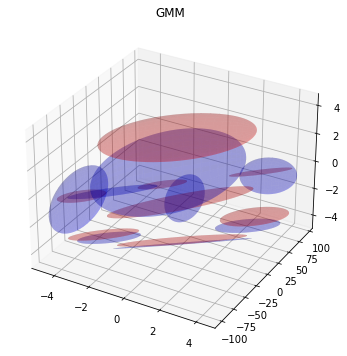

In [27]:
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111, projection='3d')
plot_gmm_3d(gmm.covariances_[:,:3,:3],gmm.means_[:,:3],ax,color='r')
plot_gmm_3d(cov_array,mu_array,ax,color='b')
#ax.plot(data[:,0],data[:,1],data[:,2],'r.',markersize=1.0)
#ax.set_xlabel(labels[0])
#ax.set_ylabel(labels[1])
#ax.set_zlabel(labels[2])
ax.set_title('GMM');

In [117]:
'''
sort and getting index of it
헷갈리는 것은 argsort로 얻는 것이, 각 요소가 몇번째 순서인가가 아닌, sorting후 몇번째 요소가 그 순서에 오는가
제일 아래 for 문으로 돌리는 곳에서 indicies[j]=i와 indicies[i]=j의 차이
'''
min_mu= np.min(mu_array,axis=0)
print(mu_array)
#print(min_mu[0])
ind=np.argsort(mu_array, axis=0)
print(ind)
mu_array_bias=np.add(mu_array,-min_mu[0])
#print(mu_array_bias)
ind1=np.argsort(mu_array_bias[:,2],axis=0)
#ind2 = sorted(range(len(mu_array_bias)),key=lambda x:float(x))# index: mu_array_bias[index])
mu_x_array = mu_array[:,2]
ind2 = sorted(range(len(mu_x_array)), key=lambda k: mu_x_array[k])# index: mu_array_bias[index])
mu_x_sorted=np.sort(mu_x_array)
indices=np.arange(mu_x_sorted.shape[0])
for i in range(mu_x_sorted.shape[0]):
    for j in range(mu_x_array.shape[0]):
        if mu_x_sorted[i]==mu_x_array[j]: indices[j]=i
    
print(mu_x_sorted)
print(ind[:,2])
print(ind2)
print(indices)

[[  3.28263108  69.51988233  -0.61080964]
 [ -2.39452085 -50.57021151  -0.26252906]
 [ -0.34193252  -8.38077869   0.57667249]
 [ -2.71118555 -48.88677983  -3.7986791 ]
 [  2.70145004  48.20947463  -3.86742202]
 [  0.19937785   4.19121648  -1.43966326]
 [ -3.63317843 -75.74467723  -0.52845133]
 [  0.1516373    2.52892373  -4.73991393]]
[[6 6 7]
 [3 1 4]
 [1 3 3]
 [2 2 5]
 [7 7 0]
 [5 5 6]
 [4 4 1]
 [0 0 2]]
[-4.73991393 -3.86742202 -3.7986791  -1.43966326 -0.61080964 -0.52845133
 -0.26252906  0.57667249]
[7 4 3 5 0 6 1 2]
[7, 4, 3, 5, 0, 6, 1, 2]
[4 6 7 2 1 3 5 0]


In [115]:
'''
원하는 dimension의 최대값과 최소값을 가지고 와서 그걸 기준으로 evenly distribute하는 
predetermined coordinates를 구하기
여기에서는 data(=demos)의 첫번째 dimension을 가지고 와서 distribute시킴
'''
min_in_desired_dim=np.amin(demos[:,2])
max_in_desired_dim=np.amax(demos[:,2])
whole_width=max_in_desired_dim-min_in_desired_dim
span=whole_width/(n_clusters0+1)
print(min_in_desired_dim,max_in_desired_dim,whole_width,n_clusters0,span)
desired_coordinates=np.arange(min_in_desired_dim+span,max_in_desired_dim*.99999,span)
print(desired_coordinates,desired_coordinates[n_clusters0-1]+span)

-4.813447076153092 5.485604949124319 10.299052025277412 8 1.1443391139197123
[-3.66910796 -2.52476885 -1.38042973 -0.23609062  0.90824849  2.05258761
  3.19692672  4.34126584] 5.485604949124318


In [182]:
clusters_pre = initialize_clusters_norm(demos, n_clusters0)
expectation_step(demos, clusters_pre)

In [192]:
'''
[ Maximization with fixe center point ]
-> One dimension (coordinate) of the derived center point is replaced by the predetermined coordinates
1. Run the same maximization algorithm 
2. Sort the derived center points in the dimension (here the first dimension = x axis) 
    where the preditemined coordinates are to set
3. Also the preditermined coordinates (in the first dimension (x axis)) are already sorted
4. Replace the coordinates (in the first dimension (x axis)) of the derived centers 
    with the predetermined coordinates in order
'''
def maximization_step_pre(X, clusters):
    global gamma_nk
    N = float(X.shape[0])
    K = len(clusters)
    
    ind = np.arange(K)
    mu_in_array=np.arange(K,dtype=float)
    mu_desired=np.arange(K,dtype=float)
    #print(mu_in_array)
    
    desired_dimension = 2
    min_in_desired_dim=np.amin(X[:,desired_dimension])
    max_in_desired_dim=np.amax(X[:,desired_dimension])
    whole_width=max_in_desired_dim-min_in_desired_dim
    
    span=whole_width/(K+1)
    desired_coordinates=np.arange(min_in_desired_dim+span,max_in_desired_dim*.99999,span)
    #print(desired_coordinates)
    
    for k, cluster in enumerate(clusters):
        gamma_k = np.expand_dims(gamma_nk[:, k], 1)
        N_k = np.sum(gamma_k, axis=0)
        # 먼저 각 (N,k)의 크기를 가지는 gamma_nk의 각 행별 값을 더해 열(axis=1, cluster의 의미)만 남김
        
        pi_k = N_k / N
        mu_k = np.sum(gamma_k * X, axis=0) / N_k
        #print(mu_k)
        cov_k = (gamma_k * (X - mu_k)).T @ (X - mu_k) / N_k
        # pi_k: 모든 시계열이 가지는 gamma_nk값을 각 클러스터 별로 더한 값을 시계열의 크기로 나눈값
        # mu_k: 모든 시계열에 (이경우 3차원 데이터) gamma_nk를 각각 곱한 값을 각 클러스터별 gamma_nk의 합계로 나눈 값
        # cov_k: 모든 시계열의 mu_k에 대한 분산에 gamma_nk를 각각 곱한 값을 각 클러스터별 gamma_nk의 합계로 나눈 값
        
        cluster['pi_k'] = pi_k
        cluster['mu_k'] = mu_k
        cluster['cov_k'] = cov_k
        #print(mu_k)
        #print(pi_k)
        mu_in_array[k]=np.array([mu_k[desired_dimension]])
  
        
    ind=np.argsort(mu_in_array, axis=0)
    for j in range(ind.shape[0]):
        #print(ind[j],mu_desired[ind[j]],desired_coordinates[j])
        mu_desired[ind[j]]=float(desired_coordinates[j])
        #print(mu_desired[ind[j]])
    #print(mu_in_array)
    #print(ind)
    #print(mu_desired)
    
    for i, cluster in enumerate(clusters):
        #print(k,ind[k])
        #print(desired_coordinates[k],desired_coordinates[ind[k]])
        #print(i)
        mu_k = cluster['mu_k']
        #print(mu_k)
        mu_k[desired_dimension] = mu_desired[i]
        cluster['mu_k'] = mu_k
        #print(mu_k)
    
#maximization_step_pre(demos, clusters_pre)

[-3.66910796 -2.52476885 -1.38042973 -0.23609062  0.90824849  2.05258761
  3.19692672  4.34126584]
[-1.94420798 -2.01753045 -1.87554823 -1.901075   -0.67313701 -1.17919656
 -1.96600876 -1.94156025]
[1 6 0 7 3 2 5 4]
[-1.38042973 -3.66910796  2.05258761  0.90824849  4.34126584  3.19692672
 -2.52476885 -0.23609062]
[-1.94420798 -2.01753045 -1.87554823 -1.901075   -0.67313701 -1.17919656
 -1.96600876 -1.94156025]


In [ ]:
'''
[ Maximization with fixe center point ]
Since the new mean (center) is not based on the gamma, pi should be updated based on the new mean (center)
'''
def maximization_step_update_only_pi(X, clusters):
    global gamma_nk
    N = float(X.shape[0])
    
    for k, cluster in enumerate(clusters):
        gamma_k = np.expand_dims(gamma_nk[:, k], 1)
        N_k = np.sum(gamma_k, axis=0)
        # 먼저 각 (N,k)의 크기를 가지는 gamma_nk의 각 행별 값을 더해 열(axis=1, cluster의 의미)만 남김
        
        pi_k = N_k / N
        #mu_k = np.sum(gamma_k * X, axis=0) / N_k
        #cov_k = (gamma_k * (X - mu_k)).T @ (X - mu_k) / N_k
        # pi_k: 모든 시계열이 가지는 gamma_nk값을 각 클러스터 별로 더한 값을 시계열의 크기로 나눈값
        # mu_k: 모든 시계열에 (이경우 3차원 데이터) gamma_nk를 각각 곱한 값을 각 클러스터별 gamma_nk의 합계로 나눈 값
        # cov_k: 모든 시계열의 mu_k에 대한 분산에 gamma_nk를 각각 곱한 값을 각 클러스터별 gamma_nk의 합계로 나눈 값
        
        cluster['pi_k'] = pi_k


In [ ]:
'''
maximization_step_pre의 기본 점검을 위한 셀
'''
clusters_pre = initialize_clusters_norm(demos, n_clusters0)
print(clusters_pre)
expectation_step(demos, clusters_pre)
maximization_step_pre(demos, clusters_pre)
print(clusters_pre)

In [203]:
def train_gmm_pre(X, n_clusters, n_epochs):
    #clusters = initialize_clusters(X, n_clusters)
    clusters = initialize_clusters_norm(X, n_clusters)
    likelihoods = np.zeros((n_epochs, ))
    scores = np.zeros((X.shape[0], n_clusters))
    history = []

    for i in range(n_epochs):
        clusters_snapshot = []
        
        # This is just for our later use in the graphs
        for cluster in clusters:
            clusters_snapshot.append({
                'mu_k': cluster['mu_k'].copy(),
                'cov_k': cluster['cov_k'].copy()
            })
            
        history.append(clusters_snapshot)
      
        expectation_step(X, clusters)
        maximization_step_pre(X, clusters)
        
        if i == (n_epochs-1):
            expectation_step(X, clusters)
            maximization_step_update_only_pi(X, clusters)

        likelihood, sample_likelihoods = get_likelihood(X, clusters)
        likelihoods[i] = likelihood

        print('Epoch: ', i + 1, 'Likelihood: ', likelihood)

    scores = np.log(gamma_nk)
    
    return clusters, likelihoods, scores, sample_likelihoods, history

In [195]:
n_clusters1=4
clusters_pre, likelihoods_pre, scores_pre, sample_likelihoods_pre, history_pre = train_gmm_pre(demos, n_clusters1, n_epochs)

[-2.75363667 -0.69382627  1.36598414  3.42579454]
[-1.47962838 -1.92704107 -1.65259822 -1.86763246]
[1 3 2 0]
[ 3.42579454 -2.75363667  1.36598414 -0.69382627]
[-1.47962838 -1.92704107 -1.65259822 -1.86763246]
Epoch:  1 Likelihood:  -100967.3524978851
[-2.75363667 -0.69382627  1.36598414  3.42579454]
[ 1.12041322 -2.82608451 -0.37722323 -1.88118011]
[1 3 2 0]
[ 3.42579454 -2.75363667  1.36598414 -0.69382627]
[ 1.12041322 -2.82608451 -0.37722323 -1.88118011]
Epoch:  2 Likelihood:  -84049.44082183935
[-2.75363667 -0.69382627  1.36598414  3.42579454]
[ 1.73423165 -2.95296605  0.0931404  -1.53847873]
[1 3 2 0]
[ 3.42579454 -2.75363667  1.36598414 -0.69382627]
[ 1.73423165 -2.95296605  0.0931404  -1.53847873]
Epoch:  3 Likelihood:  -80481.92617020299
[-2.75363667 -0.69382627  1.36598414  3.42579454]
[ 1.55129764 -2.94857079  0.20814271 -1.41043548]
[1 3 2 0]
[ 3.42579454 -2.75363667  1.36598414 -0.69382627]
[ 1.55129764 -2.94857079  0.20814271 -1.41043548]
Epoch:  4 Likelihood:  -79612.2411

[-2.75363667 -0.69382627  1.36598414  3.42579454]
[ 0.7409507  -3.1097684  -0.36476785 -1.06139544]
[1 3 2 0]
[ 3.42579454 -2.75363667  1.36598414 -0.69382627]
[ 0.7409507  -3.1097684  -0.36476785 -1.06139544]
Epoch:  34 Likelihood:  -78362.49028855714
[-2.75363667 -0.69382627  1.36598414  3.42579454]
[ 0.76622681 -3.11995426 -0.36605853 -1.02364426]
[1 3 2 0]
[ 3.42579454 -2.75363667  1.36598414 -0.69382627]
[ 0.76622681 -3.11995426 -0.36605853 -1.02364426]
Epoch:  35 Likelihood:  -78340.80457559467
[-2.75363667 -0.69382627  1.36598414  3.42579454]
[ 0.79854079 -3.13612318 -0.36854292 -0.96891141]
[1 3 2 0]
[ 3.42579454 -2.75363667  1.36598414 -0.69382627]
[ 0.79854079 -3.13612318 -0.36854292 -0.96891141]
Epoch:  36 Likelihood:  -78307.93575573311
[-2.75363667 -0.69382627  1.36598414  3.42579454]
[ 0.84158828 -3.1609176  -0.37274686 -0.88859301]
[1 3 2 0]
[ 3.42579454 -2.75363667  1.36598414 -0.69382627]
[ 0.84158828 -3.1609176  -0.37274686 -0.88859301]
Epoch:  37 Likelihood:  -78252.

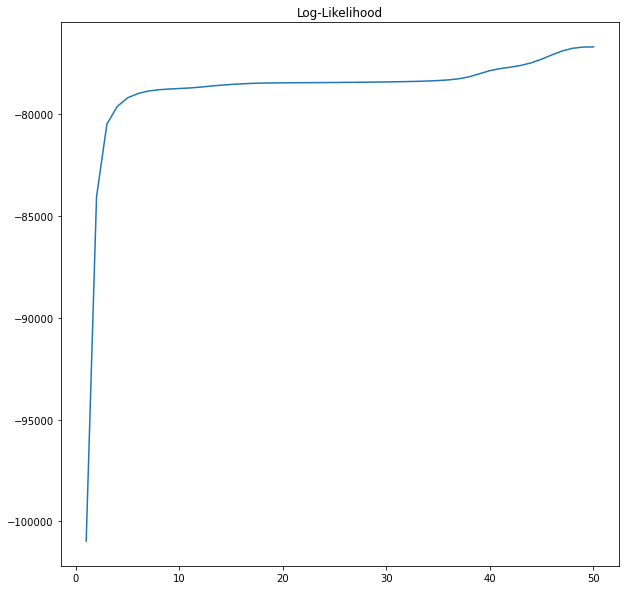

In [196]:
plt.figure(figsize=(10, 10))
plt.title('Log-Likelihood')
plt.plot(np.arange(1, n_epochs + 1), likelihoods_pre)
plt.show()

In [ ]:
def init():
    for ax, data in zip(axs, [data1, data2]):
        ydata = "Y1" if ax == axs[0] else "Y2"
        ax.set_xlabel("X", fontdict=fontlabel, labelpad=16)
        ax.set_ylabel(ydata, fontdict=fontlabel, labelpad=16)
        ax.set_title("Z", fontdict=fontlabel)
    
        ax.scatter(data["X"], data[ydata], data["Z"], 
                   c=data["Z"], cmap="inferno", s=5, alpha=0.5)
    
    return fig,

def animate(i):
    axs[0].view_init(elev=30., azim=i)
    axs[1].view_init(elev=30., azim=i)
    return fig,

# Animate
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=360, interval=20, blit=True)
# Save
anim.save('mpl3d_scatter.gif', fps=30)

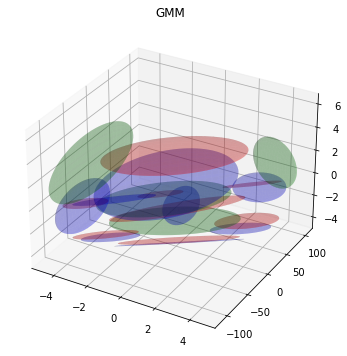

In [198]:
cov_array_pre,mu_array_pre=get_cov_and_mu_array(demos, clusters_pre)
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111, projection='3d')
plot_gmm_3d(gmm.covariances_[:,:3,:3],gmm.means_[:,:3],ax,color='r')
plot_gmm_3d(cov_array,mu_array,ax,color='b')
plot_gmm_3d(cov_array_pre,mu_array_pre,ax,color='g')
#ax.plot(data[:,0],data[:,1],data[:,2],'r.',markersize=1.0)
#ax.set_xlabel(labels[0])
#ax.set_ylabel(labels[1])
#ax.set_zlabel(labels[2])
ax.set_title('GMM');

MovieWriter ffmpeg unavailable; using Pillow instead.


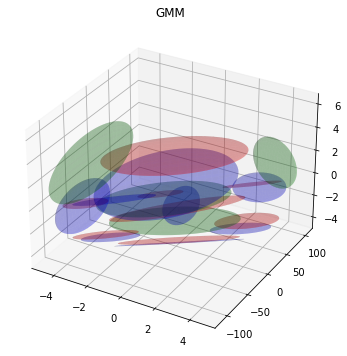

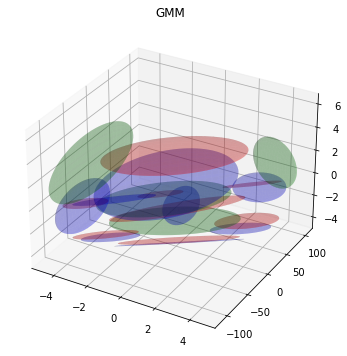

In [202]:
from matplotlib import animation 

def init():
    
    fig = plt.figure(figsize=(6,6))
    ax = fig.add_subplot(111, projection='3d')
    plot_gmm_3d(gmm.covariances_[:,:3,:3],gmm.means_[:,:3],ax,color='r')
    plot_gmm_3d(cov_array,mu_array,ax,color='b')
    plot_gmm_3d(cov_array_pre,mu_array_pre,ax,color='g')
    #ax.set_xlabel(labels[0])
    #ax.set_ylabel(labels[1])
    #ax.set_zlabel(labels[2])
    ax.set_title('GMM');
    return fig,

def animate(i):
    ax.view_init(elev=30., azim=i)
    return fig,

# Animate
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=360, interval=20, blit=True)
# Save
anim.save('mpl3d_scatter.gif', fps=30)

In [ ]:
def gaussian_mixture_regression(input_val,clusters):
    #global gamma_nk, totals
    N = input_val.shape[0]
    
    K = len(clusters)
    
    
    for k, cluster in enumerate(clusters):
        pi_k = cluster['pi_k']
        mu_k = cluster['mu_k']
        cov_k = cluster['cov_k']
        y = 
        
        
        gamma_nk[:, k] = (pi_k * gaussian(X, mu_k, cov_k)).ravel()
    
    #now gamma_nk has N-long (time series) data in the first dimension (row) and k cluster's value in the second dim (column)  
    
    totals = np.sum(gamma_nk, 1)
    
    #summing N-long time series data keeping the second (axis=1) dimension's cluster's number
    # totals.shape = (1,k)
    